In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import fourierModel as ds
from copy import copy as dup
from scipy.integrate import odeint

In [2]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0

In [3]:
# Number of iterations to calculate Nliq from Ntot
niter = 1

# Message
print("Starting a new system")
nx = 512 # Number of points in simulation box
xmax = 50
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltaX = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)

# Initialize as a pre-equilibrated layer of liquid over ice
Nice = np.zeros(boxpoints)+1 # begin with one layer of ice
Fliq = ds.getNliq(Nice,Nstar,Nbar,niter) # initialize quasi-liquid layer

    

Starting a new system


<IPython.core.display.Javascript object>


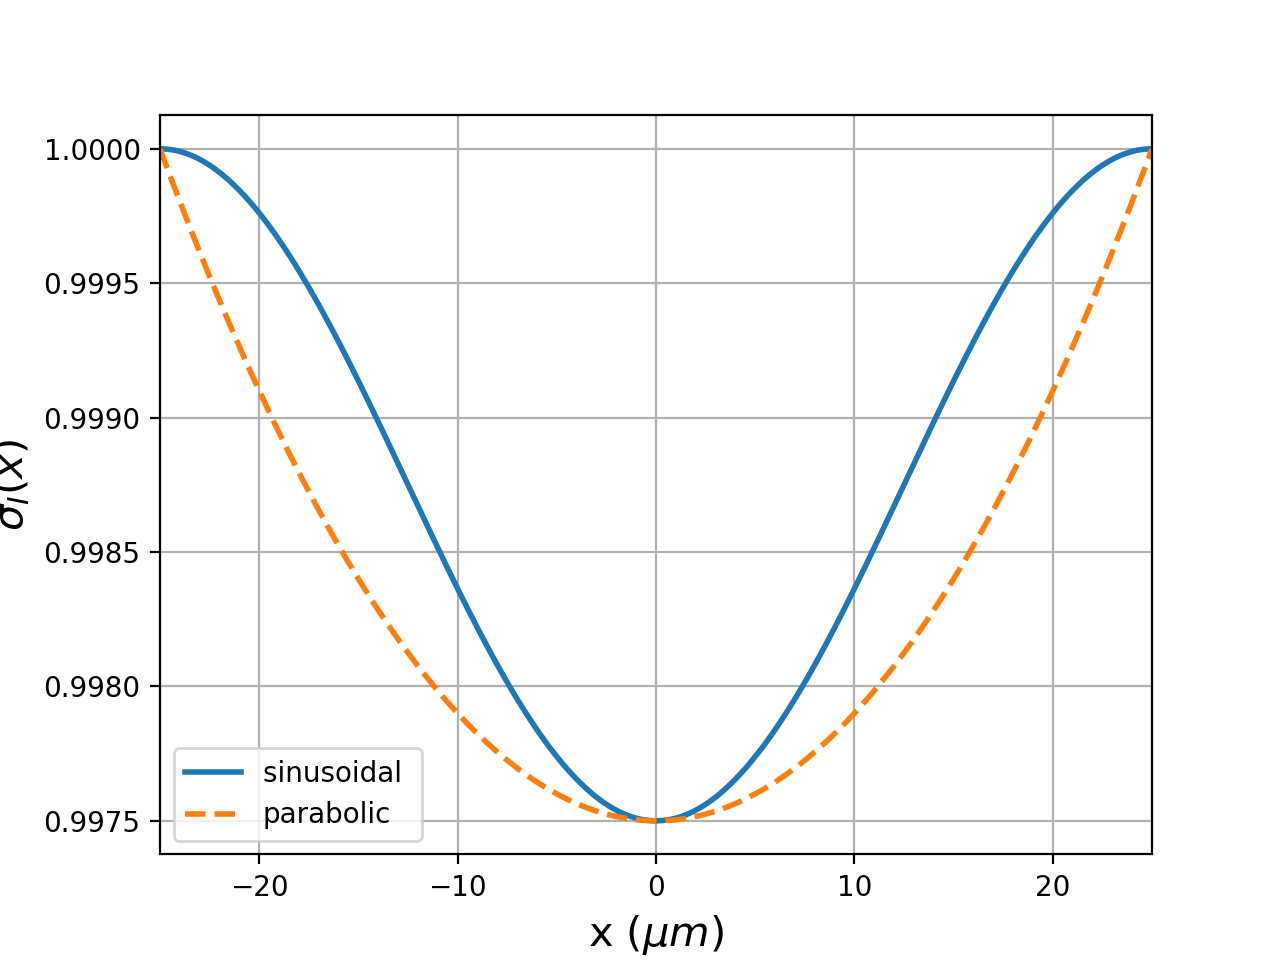

In [4]:
# Lay out the system
Ntot = Fliq + Nice     # add ice layers and quasi liquid layer to get total
nmid = int(nx/2)       # locate index of midpoint
nquart = int(nx/4)     # index of quarter point
xmid = max(x)/2        # x location of midpoint
xmax = x[nx-1]         # maximum x value
Nice_start = Nice[0]   # initial ice layer

# I'm not sure what this one does
Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Old comment: Should be close to .75; not used if D=const   

# Just conversions
nmpermonolayer = 0.3 # nanometers per layer
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6) # not sure what this is

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 10 # duplicate line of code overwritten in next line?
dtmaxtimefactor = 50 # unsure what this is
dtmax = deltaX**2/D  # I think this is the step size to guarantee stability (no longer needed in Fourier?)
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19 # I don't know exactly what this is
sigmastepmax = 0.20 # Value at edges(?), Must be bigger than sigma0 to get growth
center_reduction = 0.25 # How much lower the middle is, in percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2 # probably no longer needed in Fourier version

# Gets the function sigma(x) - higher deposition at the edges
sigmastep_sinusoid = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='sinusoid') # sinusoidal shape
sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabolic') # parabolic shape
sigmastepstyle = 'sinusoid'
if sigmastepstyle=='sinusoid':
    sigmastep = sigmastep_sinusoid
elif sigmastepstyle=='parabolic':
    sigmastep = sigmastep_parabolic
else:
    print('bad choice')

# Graph sigma(x)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid,sigmastep_sinusoid/sigmastepmax, \
         x-xmid, sigmastep_parabolic/sigmastepmax, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

In [48]:
# These are run control parameters

# Flag for explicit updating Fliq(Ntot) every step
updatingFliq = True # unsure if needed in Fourier model

# Set up a maximum number of iterations or layers
# I think for my vision of the Fourier approach, we won't need this
uselayers = True

# 1D run 
if uselayers:
    layermax_1D = 1000
else:
    countermax_1D = 15000
    

In [49]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec') # diffusion
print('deltaT_max (Diffusion time)', dtmax) # diffusion time
print('deltaT =', deltaT) # timestep(?)
print('deprate =', deprate, 'monolayers/us') # deposition rate
print('nmid', nmid) # midpoint
print('N*', Nstar) # N^*
print('N*x2pi', Nstar*2*np.pi) # 2 pi N^*
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar) # N average (what is N?) and deviation
print('deltaX', deltaX) # spatial step size
print('sigma_0 =', sigma0) # supersaturation default
print('sigmastepmax =', sigmastepmax) # deviation from default
print('center reduction', center_reduction, '%') # reduction of supersaturation in the center
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec') # max growth rate (edge)
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec') # min growth rate (center)
print('nu_kin =', nu_kin, 'um/sec') # nu-kinetic

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deltaT_max (Diffusion time) 47.87052745661972
deltaT = 0.9574105491323944
deprate = 0.16333333333333333 monolayers/us
nmid 256
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.09784735812133072
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction 0.25 %
max growth rate = 9.8 um/sec
min growth rate = 0.49000000000000044 um/sec
nu_kin = 49 um/sec


In [50]:
L = xmax/2; print(L) # half of spatial grid, micrometers
c_r = center_reduction / 100; print(c_r) # percent reduction in supersaturation in center, dimensionless
nu_kin_ml = deprate; print(nu_kin_ml) # deposition rate, monolayers per microsecond
sigma_I = sigmastepmax; print(sigma_I) # sigma at edge, dimensionless
print(D) # diffusion rate, micrometers^2/microsecond
M = np.array([.0027, .0025]) # not sure what this is
B = np.array([2.9, 1.59]) # not sure what this is
beta = np.array([0.65, 0.65]) # not sure what this is
xfactor = nu_kin_ml*L**2*c_r**beta*sigma_I/D # not sure what this is
NSS = M*xfactor + B # not sure what this is, but it's clearly something different for sine vs parabolic supersaturation profile
print('Nss predicted')
print('sinusoid:', NSS[0])
print('paraboloic:', NSS[1])

25.0
0.0025
0.16333333333333333
0.2
0.0002
Nss predicted
sinusoid: 8.510216387742963
paraboloic: 6.784644803465706


In [ ]:
# This is the 1-d run

# Timing
sec1 = time.time()

# Bundle parameters for ODE solver
params = [Nbar, Nstar, niter, sigmastep, sigma0, deprate, DoverdeltaX2, nx]

# Initial conditions for ODE solver
y0 = list((Fliq,Ntot))
ylast = dup(y0)

# Time steps
t0 = 0.0
tlast = dup(t0)
ttot = 0.0
tinterval = [t0, deltaT]

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
Fliqkeep = [dup(Fliq)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0] # initial ice layer
Nice0 = Nice[0] # current ice layer
Ntot0_start = Ntot[0] # initial total layers
Ntot0 = Ntot[0] # total layers
updatingFliq = True # not sure what this does
counter = 0 # current timestep
lastlayer = 0 # last layer of liquid
lastdiff = 0 # maximum difference between edge and center

while True:
    
    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(params,),rtol=1e-12)
    
    # reshape output into total and liquid
    ylast = np.reshape(y[1],(2,nx))
    
    # increment timestep
    tlast += deltaT
    
    # increment timestep counter
    counter += 1
        
    # Make some local copies, with possible updates to Fliq
    Fliq, Ntot = ylast
    if updatingFliq:
        Fliq = ds.getNliq(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
        ylast[0] = Fliq
    Nice = Ntot - Fliq
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltaT
    
    # Save into keeper arrays
    Nicekeep.append(Nice)
    Ntotkeep.append(Ntot)
    Fliqkeep.append(Fliq)
    tkeep.append(ttot)
    
    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print(counter-1, lastlayer, maxpoint-minpoint, maxpoint-minpoint-lastdiff)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
    if uselayers:
        if layer > layermax_1D-1:
            print('breaking because reached max number of layers')
            break
    else:
        if counter > countermax_1D-1:
            print('breaking because reached max number of iterations')
            break
            
            
sec2 = time.time()

0 0 2.918717153353384 2.918717153353384
165 1 2.9242842286692934 0.005567075315909165
330 2 2.9300121319848103 0.005727903315516869
495 3 2.935973972409144 0.005961840424333786
660 4 2.9422465167521636 0.006272544343019604
825 5 2.9489084869061486 0.006661970153984953
991 6 2.955871120765238 0.006962633859089351
1156 7 2.96341040456889 0.007539283803652097
1321 8 2.9714615952324976 0.0080511906636076
1486 9 2.9798886541004777 0.008427058867980008
1651 10 2.9882602936756086 0.008371639575130985
1817 11 2.995660081639869 0.00739978796426044
1982 12 3.0023466818156805 0.0066866001758114635
2147 13 3.0171685097203635 0.014821827904683005
2312 14 3.093913829159348 0.07674531943898444
2477 15 3.277699447664972 0.18378561850562392
2643 16 3.428681771505339 0.15098232384036692
2808 17 3.564255121295119 0.1355733497897802
2973 18 3.650572241053169 0.0863171197580499
3138 19 3.7071362300822557 0.05656398902908677
3303 20 3.7462248071904867 0.03908857710823099
3469 21 3.7707487830793696 0.0245239

28476 172 6.994469931152082 0.0033851570668161912
28643 173 6.997943139226663 0.00347320807458118
28811 174 7.000869248052766 0.002926108826102336
28979 175 7.004097135988616 0.003227887935850049
29146 176 7.011351535525705 0.007254399537089284
29314 177 7.023204242478755 0.011852706953050074
29482 178 7.045590642706657 0.022386400227901504
29650 179 7.083920207699009 0.038329564992352516
29818 180 7.140480200874208 0.056559993175199
29985 181 7.25266407450664 0.1121838736324321
30153 182 7.328834083148536 0.07617000864189549
30321 183 7.399434581712285 0.07060049856374917
30489 184 7.4614811980402465 0.0620466163279616
30657 185 7.514495031703859 0.053013833663612786
30825 186 7.559239284927742 0.044744253223882424
30993 187 7.5968974315429705 0.037658146615228816
31161 188 7.628670367770098 0.03177293622712796
31330 189 7.642210514771023 0.013540147000924208
31498 190 7.667305364694869 0.02509484992384614
31666 191 7.688801597856184 0.021496233161315104
31834 192 7.707348769706471 0.

Height of Ice 97.08235536795473
1-D growth, corner 99.00380407465454
1-D growth, center 96.22363373271101
1-D Modeled growth rate, corner, um/s 1.8968123991772268
1-D Modeled growth rate, corner, ml/us 0.006322707997257423
1-D Modeled growth rate, center, um/s 1.8435471572432218
1-D Modeled alpha, corner 0.19355257820003063
1-D Modeled alpha, center 0.1885885237158002
Difference, % -2.564705947290576
Libbrecht's predicted growth rate, um/s 1.8393582063217946
Libbrecht's predicted alpha 0.18768961288997904
Time taken: 7 min 48.425331115722656 secs


<IPython.core.display.Javascript object>


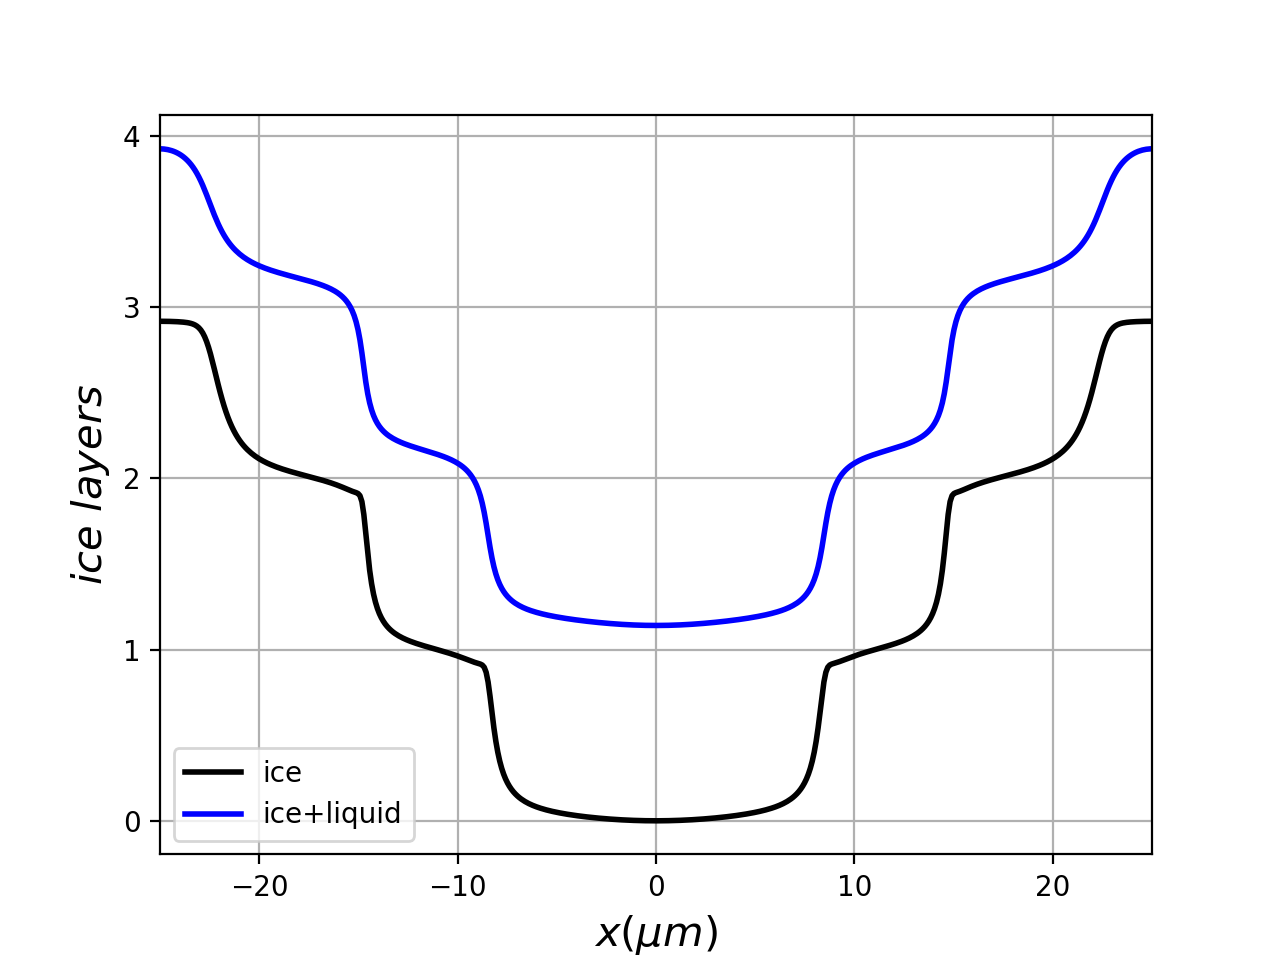

<IPython.core.display.Javascript object>


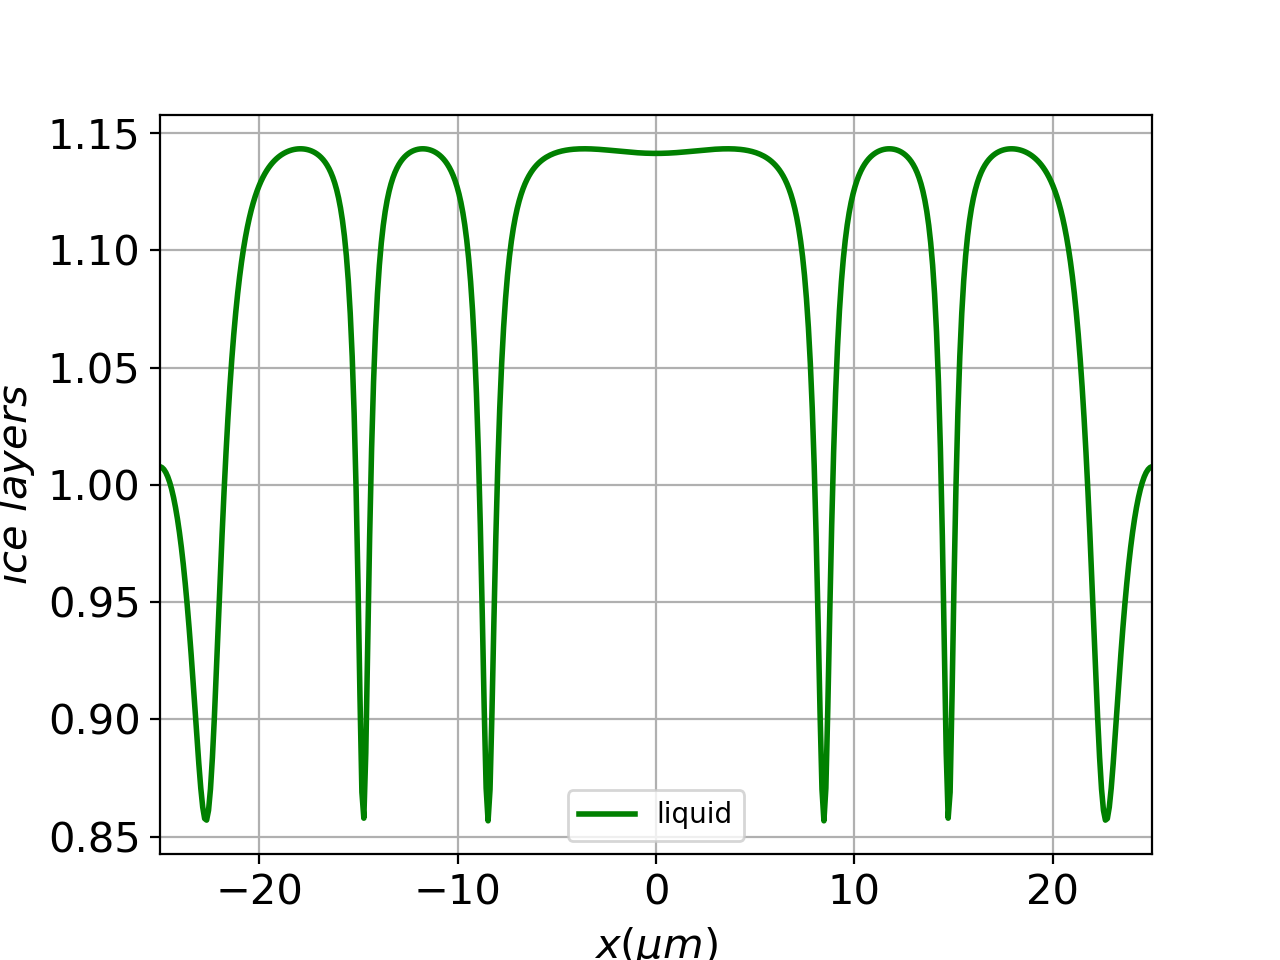

<IPython.core.display.Javascript object>


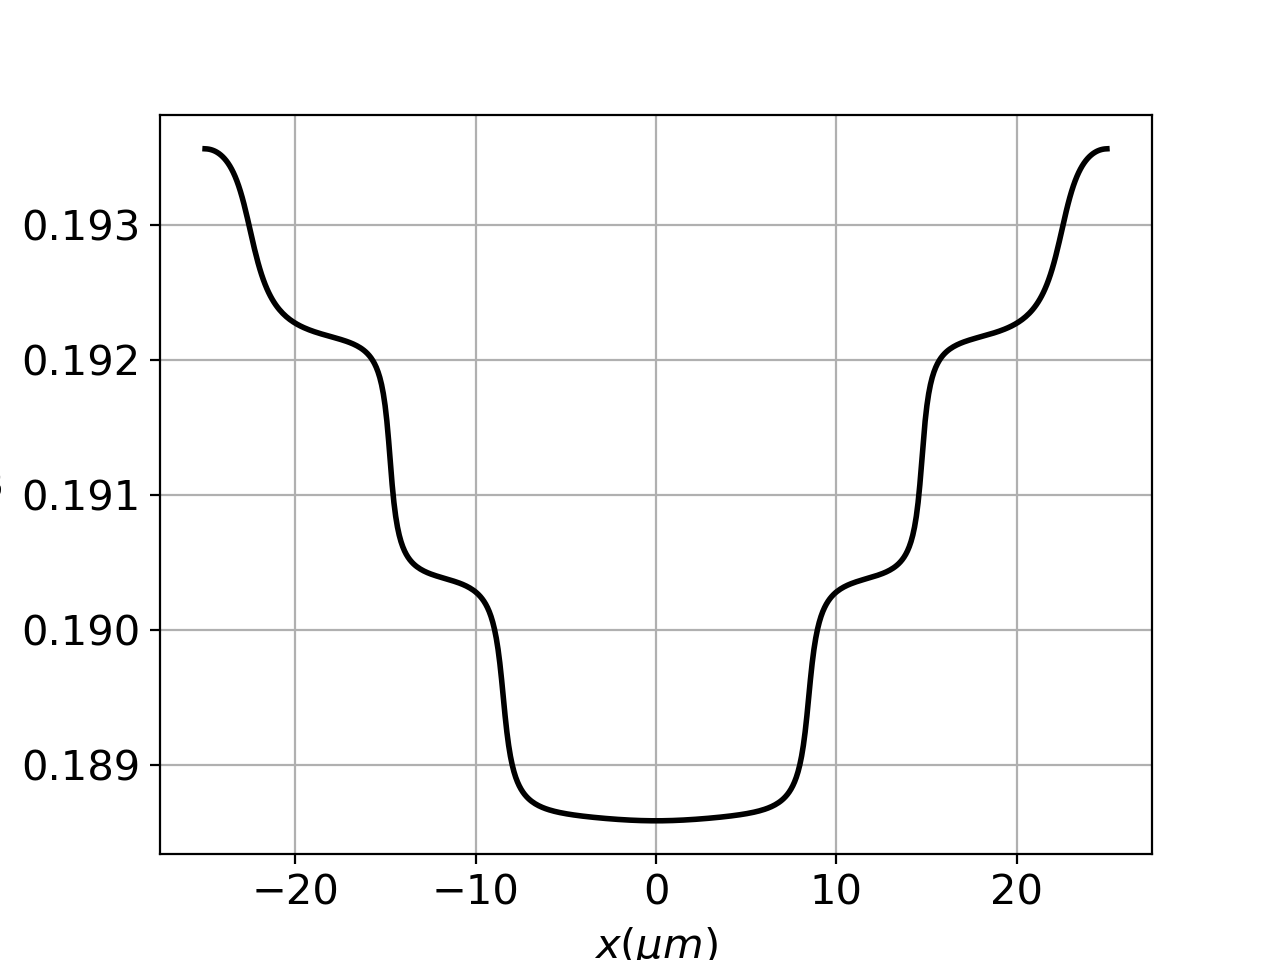

In [10]:
# Growth statistics
minpoint = min(Nice)
ncorner = 4 # why is ncorner 4 and not 0?

# total height of ice
print("Height of Ice", minpoint)

 # change in total ice depth at each grid point
delta_Ntot_entire = Ntot-Ntotkeep[0]

# growth at corner and in center
print( "1-D growth, corner", delta_Ntot_entire[ncorner])
print( "1-D growth, center", delta_Ntot_entire[nmid])

# growth over time (growth rate)
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus) # why different units on this one?
print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])

# alpha is some other modified growth rate
alpha = growthrate_entire/nu_kin/sigmastep
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmid])
print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
print("Libbrecht's predicted alpha", alpha_L)

# Timing statistics
print("Time taken:", int((sec2-sec1)/60), "min", (sec2-sec1)%60, "secs")

#########
# Plots #
#########

# First plot: layers (rescaled to have minimum at zero, shifted so center of facet is at zero)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Nice-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Fliq+Nice-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Second plot: liquid layer alone
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Fliq, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Third plot: alpha (a measure of growth rate at each point)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, alpha, 'k', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ \alpha $',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')


<IPython.core.display.Javascript object>


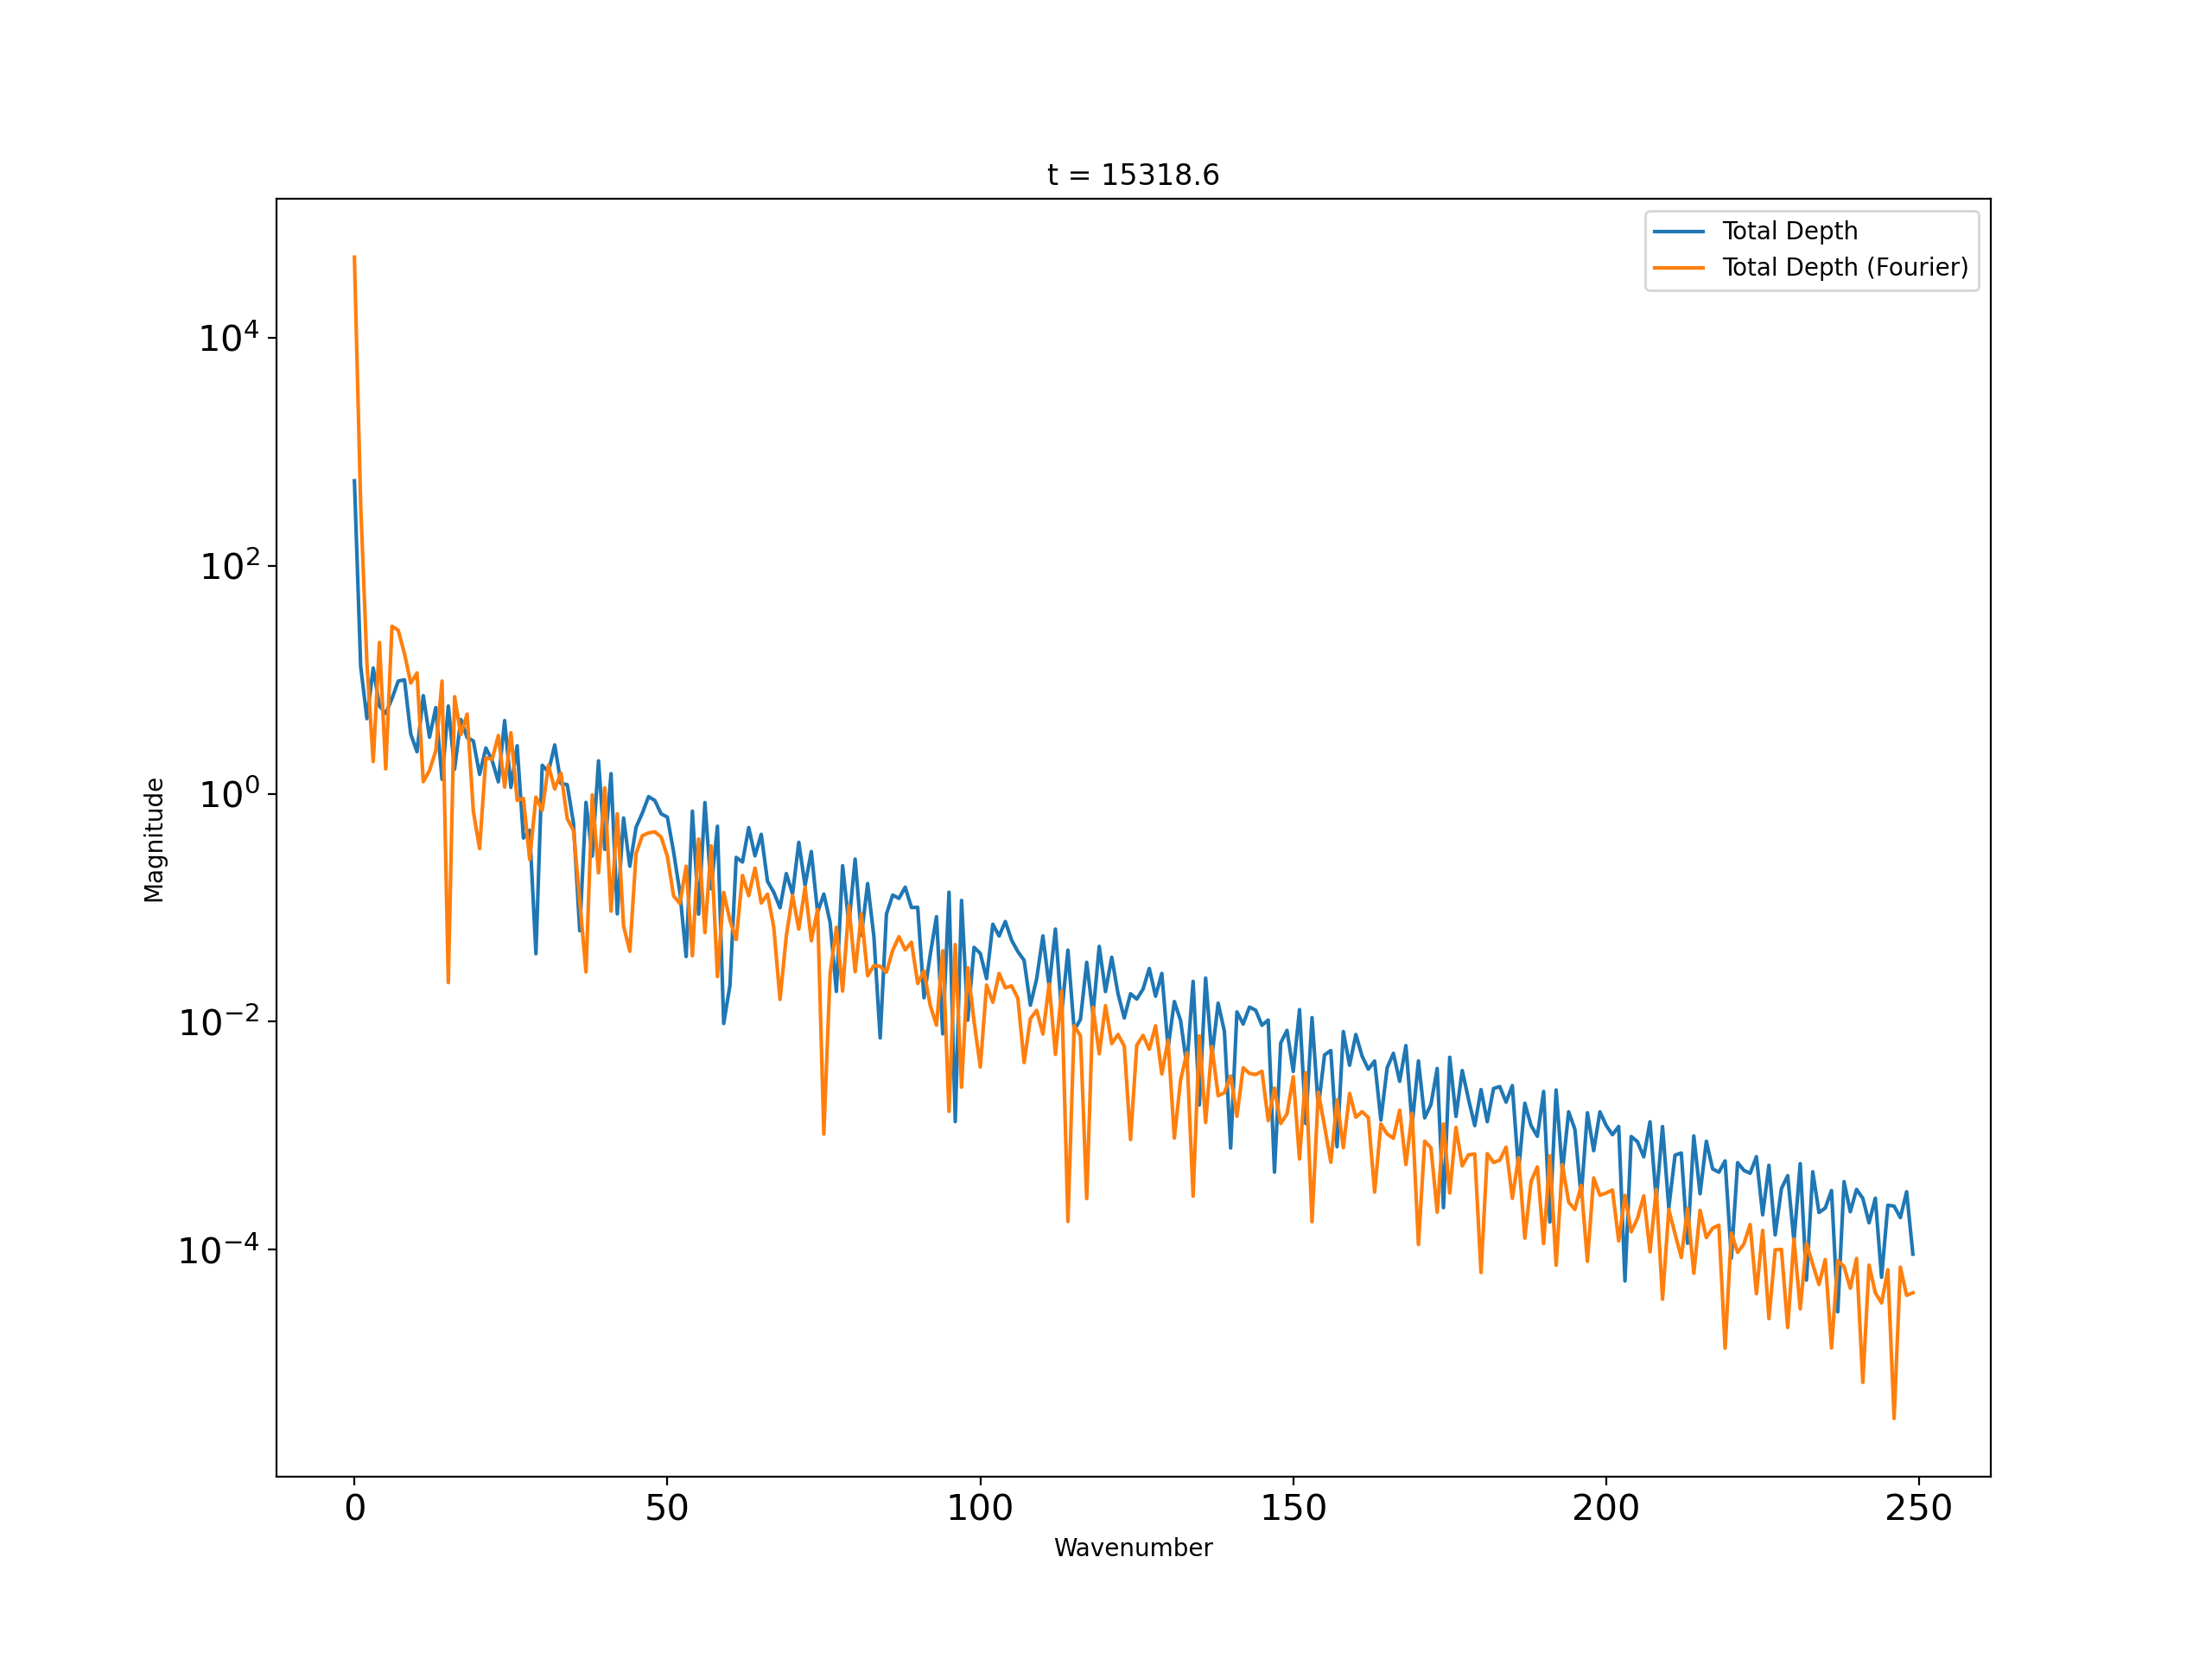

In [11]:
fignum = 9
plt.figure(fignum)
plt.semilogy(np.abs(np.fft.fft(ylast[0,])[0:250]))
plt.semilogy(np.abs(np.fft.fft(ylast[1,])[0:250]))
plt.title("Magnitude of Fourier modes at 100 Layers (log scale)")
plt.xlabel("Wavenumber")
plt.ylabel("Magnitude")
plt.legend(["Total Depth","QLL Depth"])

<IPython.core.display.Javascript object>


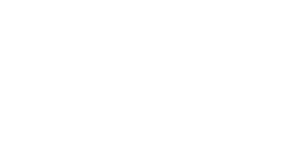

/Users/jrprice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/jrprice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


In [13]:
from matplotlib import animation
from IPython.display import HTML

# make animation of the Fourier frequency spectrum over time
Ntotanim = Ntotkeep[0::1000]
Fliqanim = Fliqkeep[0::1000]
tanim = tkeep[0::1000]

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = 0,xmax = 250,ymin = -20, ymax = 10)
    
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(2)]

legendList = ["Total Depth","Qll Depth"]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(np.arange(0,256),np.log(np.abs(np.fft.fft(Ntotanim[n])[0:256])))
    lineList[1][0].set_data(np.arange(0,256),np.log(np.abs(np.fft.fft(Fliqanim[n])[0:256])))
    plt.title('t = '+str(round(tanim[n],1)))
    plt.legend(legendList, loc = "upper right")
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

plt.close()
HTML(anim.to_jshtml())

<IPython.core.display.Javascript object>


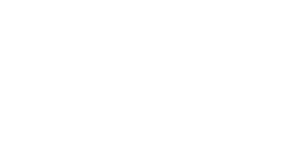

In [14]:
# animation of facet depth over time



Ntotanim = Ntotkeep[0::1000]
Niceanim = Nicekeep[0::1000]
Fliqanim = Fliqkeep[0::1000]
tanim = tkeep[0::1000]

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = min(x-xmid),xmax = max(x-xmid),ymin = 0, ymax = 10)
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(2)]

legendList = ["Total Depth","Qll Depth"]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(x-xmid,Niceanim[n]-min(Niceanim[n]))
    lineList[1][0].set_data(x-xmid,Fliqanim[n]+Niceanim[n]-min(Niceanim[n]))
    plt.title('t = '+str(round(tanim[n],1)))
    plt.legend(legendList, loc = "upper right")
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

plt.close()
HTML(anim.to_jshtml())



<IPython.core.display.Javascript object>


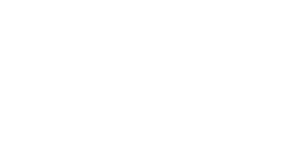

In [47]:
Ntotanim = Ntotkeep[0::1000]
Niceanim = Nicekeep[0::1000]
Fliqanim = Fliqkeep[0::1000]
tanim = tkeep[0::1000]

maxK = 128
maxInd = np.shape(Niceanim[0])[0]
step = int(512/(2*maxK))
indices = np.concatenate([np.arange(0,maxK),np.arange(maxInd-maxK,maxInd)])

xred = np.linspace(0, xmax, maxK*2)

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = min(x-xmid),xmax = max(x-xmid),ymin = 0, ymax = 4)
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[],[],[]) for i in range(4)]

legendList = ["Total Depth","Total Depth (Fourier)","QLL Depth","QLL Depth (Fourier)"]

# define function to draw each frame
def makeFrame(n):
    NiceFreq = np.fft.fft(Niceanim[n])/(512)
    NiceFreqTrunc = NiceFreq[indices]
    Nice2 = np.real(np.fft.ifft(NiceFreqTrunc)*(2*maxK))
    
    lineList[0][0].set_data(x-xmid,Niceanim[n]-min(Niceanim[n]))
    lineList[1][0].set_data(xred-xmid,Nice2-min(Nice2))
    
    FliqFreq = np.fft.fft(Fliqanim[n])/(512)
    FliqFreqTrunc = FliqFreq[indices]
    Fliq2 = np.real(np.fft.ifft(FliqFreqTrunc)*(2*maxK))
    
    lineList[2][0].set_data(x-xmid,Fliqanim[n]+Niceanim[n]-min(Niceanim[n]))
    lineList[3][0].set_data(xred-xmid,Fliq2+Nice2-min(Nice2))
    plt.title('t = '+str(round(tanim[n],1)))
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

plt.close()
HTML(anim.to_jshtml())

In [43]:
np.linspace(0, xmax, maxK*2).shape

(16,)

In [33]:
len(Niceanim)

17

In [65]:
512/(2*maxK)

16.0

In [53]:
?np.arange